## Data Science: Final Project
* [Task 1: Balancing the Dataset](#first-bullet)


In [2]:
import psycopg2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
import sys
import time
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.exceptions import ConvergenceWarning
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectKBest

### Task 1: Knowing our Data

In [2]:
# Reading the fake news corpus
corpus_news = pd.read_csv('cleaned.csv')
print(corpus_news)
corpus_news = corpus_news[['content', 'type']].drop_duplicates().dropna(axis = 0, how = 'any')


# Reading the scraped data
scraped_news = pd.read_csv('cleaned_scraped_data.csv')
scraped_news = scraped_news[['content','type']].drop_duplicates().dropna(axis = 0, how = 'any')

# Mergin' the data (We need to clean the scraped news as welL!)
all_news = corpus_news.append(scraped_news)

        Unnamed: 0      id              domain        type  \
0                0  694410        dailykos.com   political   
1                1  694411        dailykos.com   political   
2                2  694412        dailykos.com   political   
3                3  694413  www.emptywheel.net         NaN   
4                4  694414        ecowatch.com   political   
...            ...     ...                 ...         ...   
999929       99995  238423      wikispooks.com  conspiracy   
999930       99996  238424      wikispooks.com  conspiracy   
999931       99997  238425      wikispooks.com  conspiracy   
999932       99998  238426      wikispooks.com  conspiracy   
999933       99999  238427      wikispooks.com  conspiracy   

                                                      url  \
0       https://www.dailykos.com/stories/2011/12/27/10...   
1       https://www.dailykos.com/stories/2011/10/14/10...   
2       https://www.dailykos.com/stories/2011/10/5/102...   
3       htt

C:\Users\DavidAndreasSeiler-H\AppData\Local\Temp\ipykernel_28496\1879596140.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_news = corpus_news.append(scraped_news)


Classifications: 620053



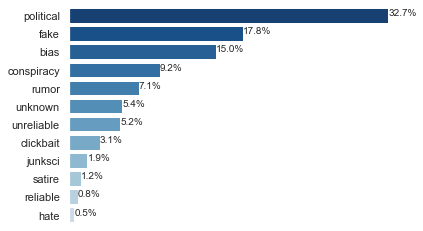

In [3]:
# Visualisations
data = corpus_news
print(f'Classifications: {len(corpus_news)}')
print()

article_counts = data['type'].value_counts()
article_pct = data['type'].value_counts(normalize=True).round(4)*100

x = article_pct
y = article_pct.index
percentage = article_pct

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white','figure.figsize':(11.7,8.27)})
sns.set_palette('Reds', n_colors=None, desat=None, color_codes=False)

palette = sns.color_palette("Blues",n_colors=15)
palette.reverse()

ax = sns.barplot(x=x,y=y, palette = palette)
patches = ax.patches
ax.set(xlabel=None)

for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/100)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
sns.despine(bottom = True, left = False)
ax.set(xticks=[])
plt.show()

#### Making news grouping
We need to make two classification categories from 12 possible categories. There are several ways to do this. An obvious approach would be to put all types labeled fake in one category and everything else in another. What we care about is distinguishing between whether something is fake news or not. We do not not care about identifying e.g. hate articles, clickbait or junksci. We just use these types as examples of something that is not fake news even though these are also undeseriable article types on e.g. a news platform.We do not believe, that a classifier will be able to distinguish between satire and fake news, therefore we remove the satire articles entirely. 

#### Balancing the Dataset
The handed out fake news dataset is imbalanced as the non fake news articles constitute almost twice as many articles (after filteren nans) than the rest of the data. Furthmore within the non-fake news data reliable articles only constitute a small percentage. Therefore we enrich this data with the scraped data and then we random remove articles from the non-fake news data to get the same amount of articles in each dataset. Here it is important to note, that we assume, that the wikinews articles are reliable. Going from an imbalanced to balanced dataset improves our baseline accuracy around

In [4]:
# Classifying types
remove = ['unknown', 'satire']
fake = ['fake']
not_fake = ['political', 'reliable', 'bias', 'conspiracy', 'rumor', 'unreliable', 'clickbait', 'junksci', 'hate']

all_news = all_news[~all_news['type'].isin(remove)]
fake_news = all_news[all_news['type'].isin(fake)].copy()
not_fake_news = all_news[all_news['type'].isin(not_fake)].copy()
not_fake_news['type'] = 'not fake' 

# Number of articles in each set
count_group_1 = len(fake_news)
count_group_2 = len(not_fake_news)

not_fake_news = not_fake_news.sample(n=count_group_1)

all_news = not_fake_news.append(fake_news)
all_news.to_csv('all_news.csv')

print(f'Length of not fake news: {len(not_fake_news)}')
print(f'Length of fake news: {len(fake_news)}')
print(f'Length of all news: {len(all_news)}')

C:\Users\DavidAndreasSeiler-H\AppData\Local\Temp\ipykernel_2436\2426373765.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_news = not_fake_news.append(fake_news)


Length of not fake news: 110071
Length of fake news: 110071
Length of all news: 220142


#### Task 2: Establishing a Baseline
Naive Bayes and logistic regression. SVM possibe using a linear kernel.

In [12]:
all_news = pd.read_csv('all_news.csv', nrows =1000)
all_news['type'] = all_news['type'].map({'fake':1, 'not fake':0})

x = all_news['content'].values
y = all_news['type'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1000)

# Apply tfid vectorization
vectorizer = CountVectorizer()
vectorizer.fit(x_train)
x_train = vectorizer.transform(x_train) #.toarray()
x_test = vectorizer.transform(x_test)

In [17]:
#Feature Selection 

SELECT_CHI2 = int(len(all_news)*0.10)
print("Extracting %d best features by a chi-squared test" % SELECT_CHI2)
ch2 = SelectKBest(chi2, k=SELECT_CHI2)
x_train = ch2.fit_transform(x_train, y_train)
x_test = ch2.transform(x_test)
print(type(x_train))

Extracting 100 best features by a chi-squared test
<class 'scipy.sparse._csr.csr_matrix'>


In [16]:
# Logistic Regression for fake news prediction
classifier = LogisticRegression(max_iter = 1000, penalty ='l2') # konvergensen er fin btw, vi har ikke store ændringer i vores fejl, når
# vi ændrer i antallet af iterationer.
classifier.fit(x_train, y_train)
score = classifier.score(x_test, y_test)
print(f'Score for logistic baseline: {score}')

# Naive Bayes for fake news prediction
gnb = BernoulliNB()
gnb.fit(x_train, y_train)
score = gnb.score(x_test, y_test)
print(f'Score for naive Bayes baseline: {score}')

# SVM for fake news prediction
#svm = svm.SVC(kernel='linear')
#svm.fit(x_train, y_train)
#score = gnb.score(x_test, y_test)
#print(f'Score for SVM baseline: {score}')

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

In [12]:
# Confusion matrix
y_pred = classifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred, labels=all_news['type'].unique())
df_cm = pd.DataFrame(cm, index=all_news['type'].unique(), columns=all_news['type'].unique())

df_cm_percentage = df_cm.copy()
for i in df_cm_percentage:
    df_cm_percentage[i]=df_cm_percentage[i]/df_cm_percentage[i].sum()
df_cm_percentage 

,0,1
0,0.921533,0.022284
1,0.078467,0.977716


#### Task 3: Creating a Fake News Predictor

In [94]:
# Use another model and use k-fold cross validation
# Support vector machine with (non-linear boundaries)
#print(x_train)
#sys.exit(2)

clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(8,4), random_state=1,max_iter=100, activation = 'logistic')

"0,0,10,10"

clf.fit(x_train, y_train)

score = clf.score(x_test, y_test)
print(score)

C:\Users\DavidAndreasSeiler-H\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.9593143860817952


a model with zero hidden layers will resolve linearly separable data. So unless you already know your data isn't linearly separable, it doesn't hurt to verify this--why use a more complex model than the task requires? If it is linearly separable then a simpler technique will work, but a Perceptron will do the job as well.

HOW TO CHECK IF LINEAR SEPEARBAL??

WHICH FEATURES TO ADD? 

Just guess baseline

In [95]:
y_pred = clf.predict(x_test)
cm = confusion_matrix(y_test, y_pred, labels=all_news['type'].unique())
df_cm = pd.DataFrame(cm, index=all_news['type'].unique(), columns=all_news['type'].unique())

df_cm_percentage = df_cm.copy()
for i in df_cm_percentage:
    df_cm_percentage[i]=df_cm_percentage[i]/df_cm_percentage[i].sum()
df_cm_percentage 

,0,1
0,0.944159,0.02451
1,0.055841,0.97549


#### Task 4: Performance Beyond the Original Dataset

In [97]:
# check om metoden her er korrekt
liar_data = pd.read_csv('train.tsv', sep='\t', header = None)
print(len(liar_data))
x_test = vectorizer.transform(liar_data[liar_data.columns[2]])
y_test = liar_data[liar_data.columns[1]].map({'false':1}).replace(float('nan'),0)
print(y_test)
score = clf.score(x_test, y_test)
print(score)

10240
0        1.0
1        0.0
2        0.0
3        1.0
4        0.0
        ... 
10235    0.0
10236    0.0
10237    0.0
10238    1.0
10239    0.0
Name: 1, Length: 10240, dtype: float64
0.80498046875


In [93]:
x_train.shape

(154099, 413525)